# Credit Line | EDA | DataShift

In [1]:
import sys
sys.path.append('..')
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import calplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd


import utils
from utils.eda import ridge_plot
from utils.eda import area_plot
from utils.eda import na_datashift

In [2]:
DATA_PATH = os.path.join('..', 'data', 'raw', 'raw.csv')

In [3]:
data = pd.read_csv(
    DATA_PATH,
    index_col='AppId',
    parse_dates=['dtstart', 'birthday'],
)

In [4]:
# data = data.drop(columns=[
    
#     # targets
#     '30_2mob',
#     '30_3mob',
#     '90_6mob',
#     '90_12mob',

#     # data leak
#     'verification',
#     'EmployeeId',
    
#     # поля-разделители
#     'Сервис3',
#     'risk',
#     'Comment',
#     'clientid',
#     'ds_ver',

#     # origin
#     'citizenshipid',  # полностью повторияет `nation`
#     'spouseincome',  # константный признак
#     'amountoriginal',  # полностью повторияет `Loan amount`
#     'client_type',  # константный признак
#     'educationid',  # константный признак
#     'bankrupt',  # константный признак
#     'monthlycreditpayment',  # константный признак
    
#     # NBKI
#     'Timestamp',  # Есть старые запросы до года, однако их очень мало. В основном запросы не старше суток
#     'Recent_account_date',  # Всего 743 non-null
#     'Oldest_account_date',  # Всего 743 non-null
#     'Total_disputed',  # константный признак
#     'Total_letigation',  # константный признак
#     'Total_bankruptcy',  # константный признак
#     'RCC_overdue_amount',  # константный признак
#     'Fico_score',  # не можем получать
#     'Reg_region', # неинформативный признак
#     'Liv_region', # неинформативный признак

#     # Equifax
#     'Timestamp_eq',  # Есть старые запросы до года, однако их очень мало. В основном запросы не старше суток
#     'Recent_account_date_eq',  # Всего 2060 non-null
#     'Oldest_account_date_eq',  # Всего 2060 non-null
# #     'Payment_cards',  # константный признак
#     'Total_bankruptcy_eq',  # константный признак
#     'Total_letigation_eq',  # константный признак
#     'RCC_credit_limit_eq',  # константный признак
#     'RCC_overdue_amount_eq',  # константный признакы
# ])

data = data.query('dtstart < "2023-08-01"')

data['age'] = ((data['dtstart'] - data['birthday']) / np.timedelta64(1, 'Y'))
data = data.drop(columns='birthday')
data['day'] = data['dtstart'].dt.day
data['weekday'] = data['dtstart'].dt.weekday.astype('category')
data['seconds'] =  pd.to_timedelta(data['dtstart'].dt.time.astype(str)).dt.total_seconds()

data['60_6mob'] = data['60_6mob'].apply(lambda x: 0 if str(x) == '0.0' else 1)  # Предобработка таргета
data["30_2mob"] = data["30_2mob"].apply(lambda x: 0 if str(x) == "0.0" else 1)
# data['sigdoc'] = data['sigdoc'].astype(int)

data.head()

,ds_ver,clientid,client_type,dtstart,amountoriginal,CategoryGoodsId,InitialFee,AmountPurchaseOriginal,sex,citizenshipid,...,loan_amount,30_2mob,30_3mob,60_6mob,90_6mob,90_12mob,age,day,weekday,seconds
AppId,,,,,,,,,,,,,,,,,,,,,
888776,2023_07_05_0,698513,0,2020-03-20 17:53:00,18872.0,8,4718.0,23590.0,1.0,417,...,18872.0,0,0.00,0,0.00,0.00,42.434918,20,4,64380.0
890354,2023_07_05_0,699647,0,2020-03-21 00:00:00,20471.2,8,5117.8,25589.0,2.0,417,...,20471.2,0,0.00,0,0.00,0.00,29.427397,21,5,0.0
890401,2023_07_05_0,699681,0,2020-03-21 17:55:00,13128.0,8,3282.0,16410.0,2.0,417,...,13128.0,1,9434.12,1,9434.12,0.00,29.588347,21,5,64500.0
890489,2023_07_05_0,699747,0,2020-03-21 19:00:00,14519.2,8,3629.8,18149.0,1.0,417,...,14519.2,0,0.00,0,0.00,5633.98,24.580251,21,5,68400.0
891426,2023_07_05_0,700419,0,2020-03-22 13:36:00,21502.4,8,5375.6,26878.0,2.0,417,...,21502.4,0,0.00,0,0.00,0.00,37.831689,22,6,48960.0


In [5]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 24350 entries, 888776 to 1912560
Data columns (total 136 columns):
 #    Column                         Non-Null Count  Dtype         
---   ------                         --------------  -----         
 0    ds_ver                         24350 non-null  object        
 1    clientid                       24350 non-null  int64         
 2    client_type                    24350 non-null  int64         
 3    dtstart                        24350 non-null  datetime64[ns]
 4    amountoriginal                 24350 non-null  float64       
 5    CategoryGoodsId                24350 non-null  int64         
 6    InitialFee                     24350 non-null  float64       
 7    AmountPurchaseOriginal         24350 non-null  float64       
 8    sex                            24189 non-null  float64       
 9    citizenshipid                  24350 non-null  int64         
 10   domen                          14500 non-null  object        
 11 

In [6]:
TARGET_COLNAME = '60_6mob'
DATE_COLNAME = 'dtstart'

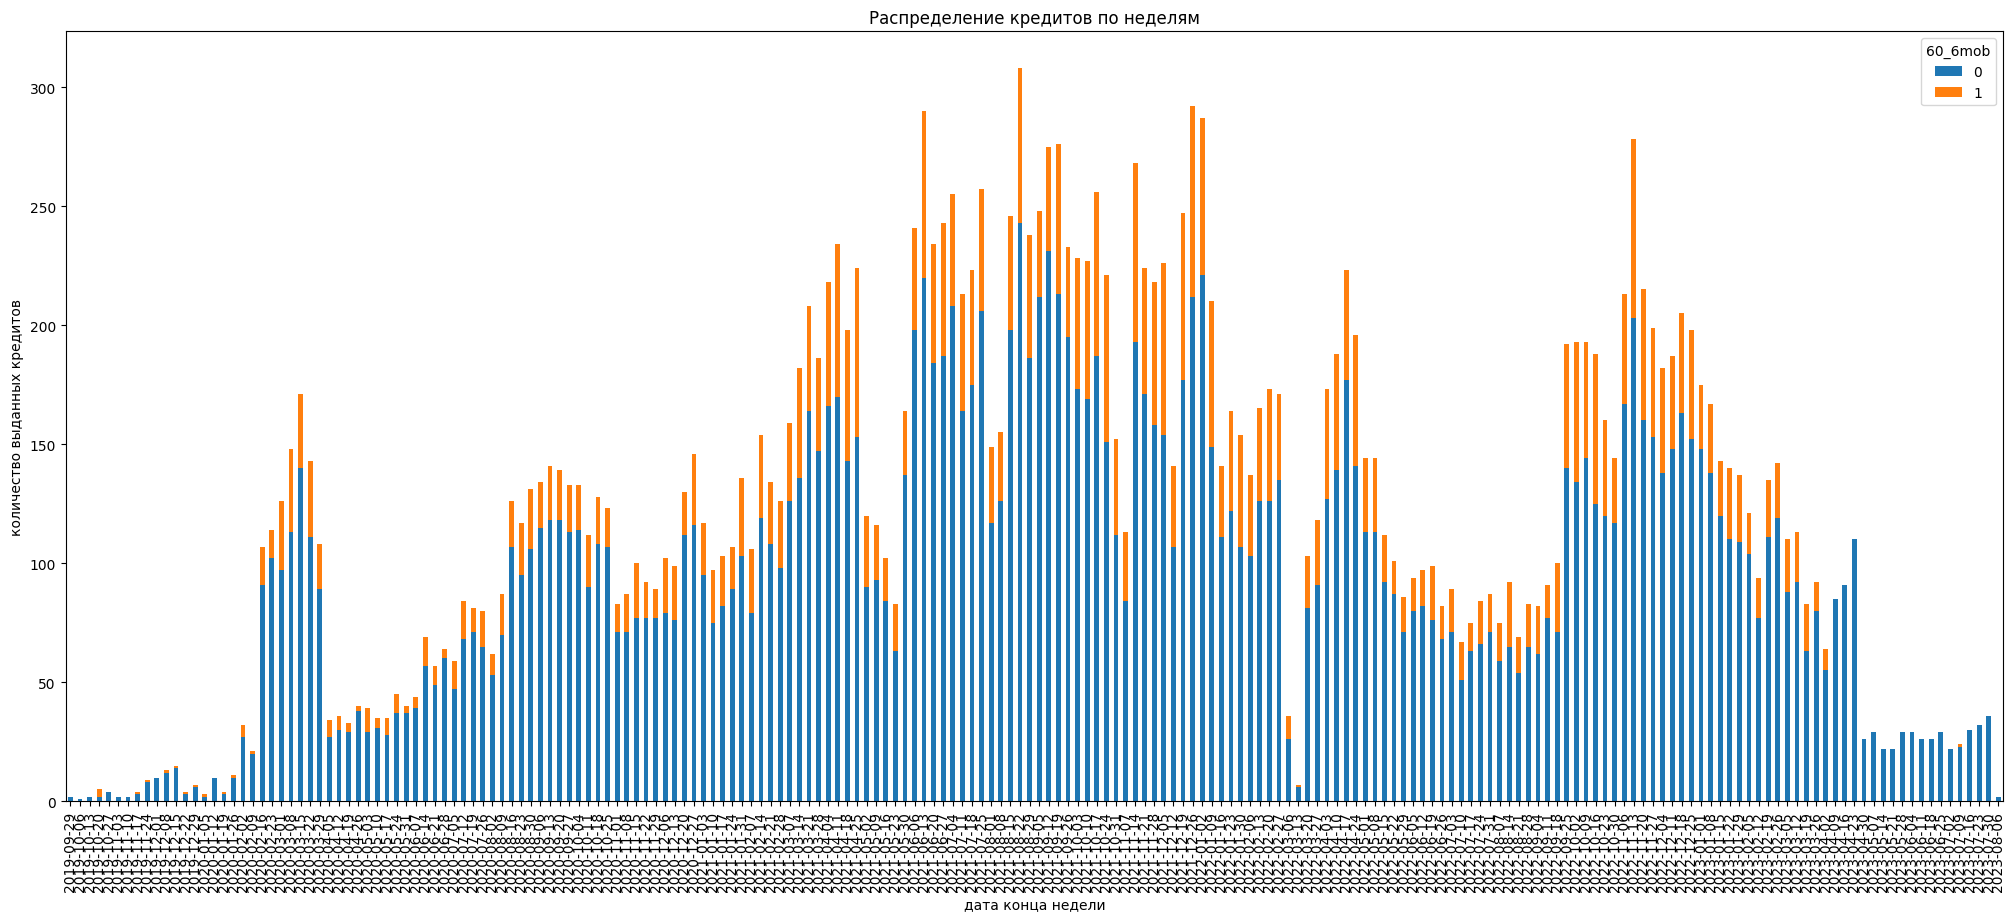

In [8]:
grouped = data.groupby([pd.Grouper(key='dtstart', freq='W'), '60_6mob'])['seconds'].count().unstack()

fig, ax = plt.subplots(figsize=(25, 10))

grouped.plot(ax=ax, kind='bar', stacked=True, rot=90, title='Распределение кредитов по неделям')
ax.set_ylabel('количество выданных кредитов')
ax.set_xlabel('дата конца недели')
ax.set_xticklabels(grouped.index.format())

plt.show()

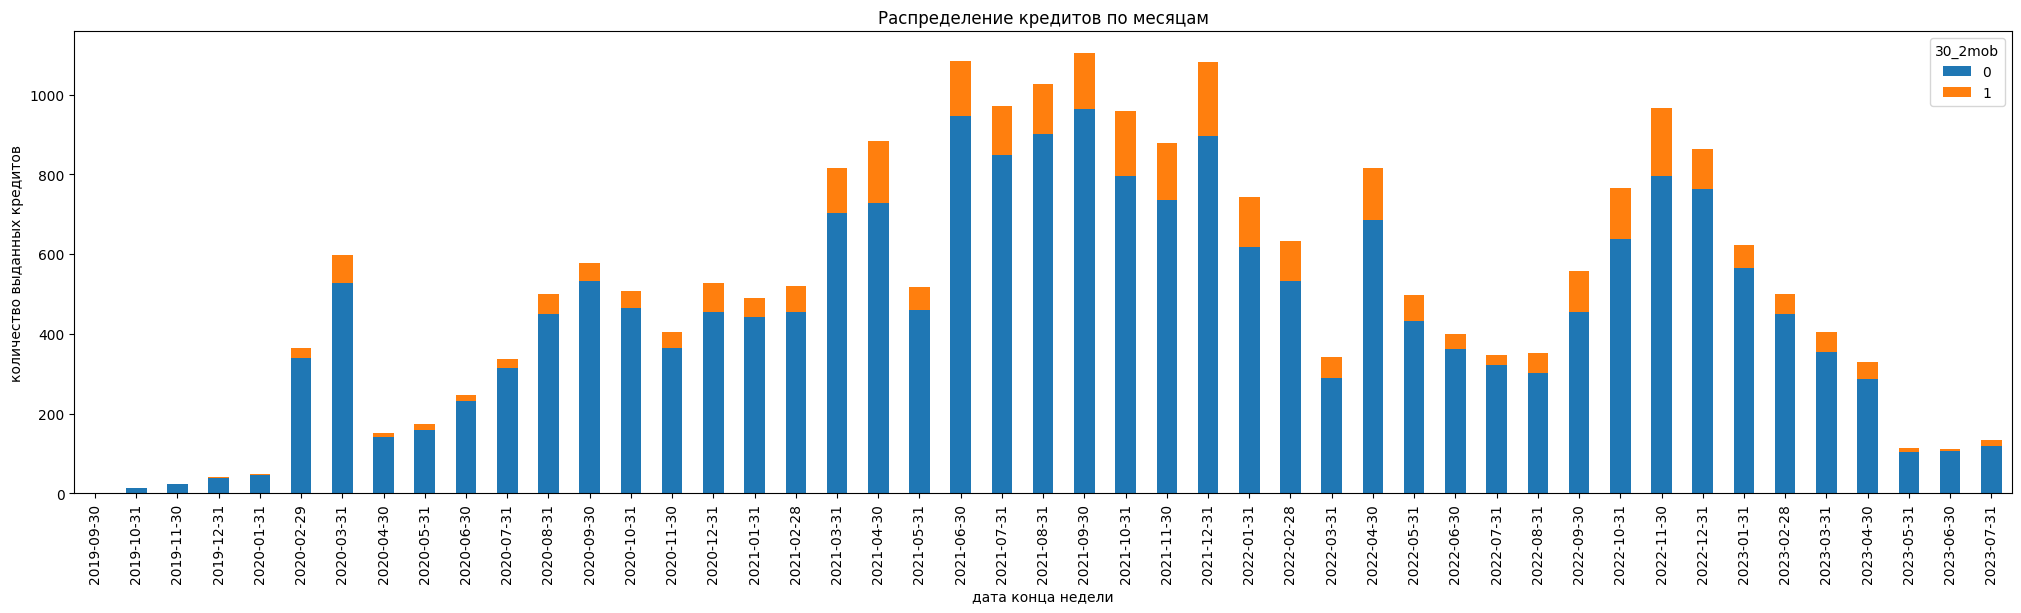

In [28]:
grouped = data.groupby([pd.Grouper(key='dtstart', freq='M'), '30_2mob'])['seconds'].count().unstack()

fig, ax = plt.subplots(figsize=(25, 6))

grouped.plot(ax=ax, kind='bar', stacked=True, rot=90, title='Распределение кредитов по месяцам')
ax.set_ylabel('количество выданных кредитов')
ax.set_xlabel('дата конца недели')
ax.set_xticklabels(grouped.index.format())

plt.show()

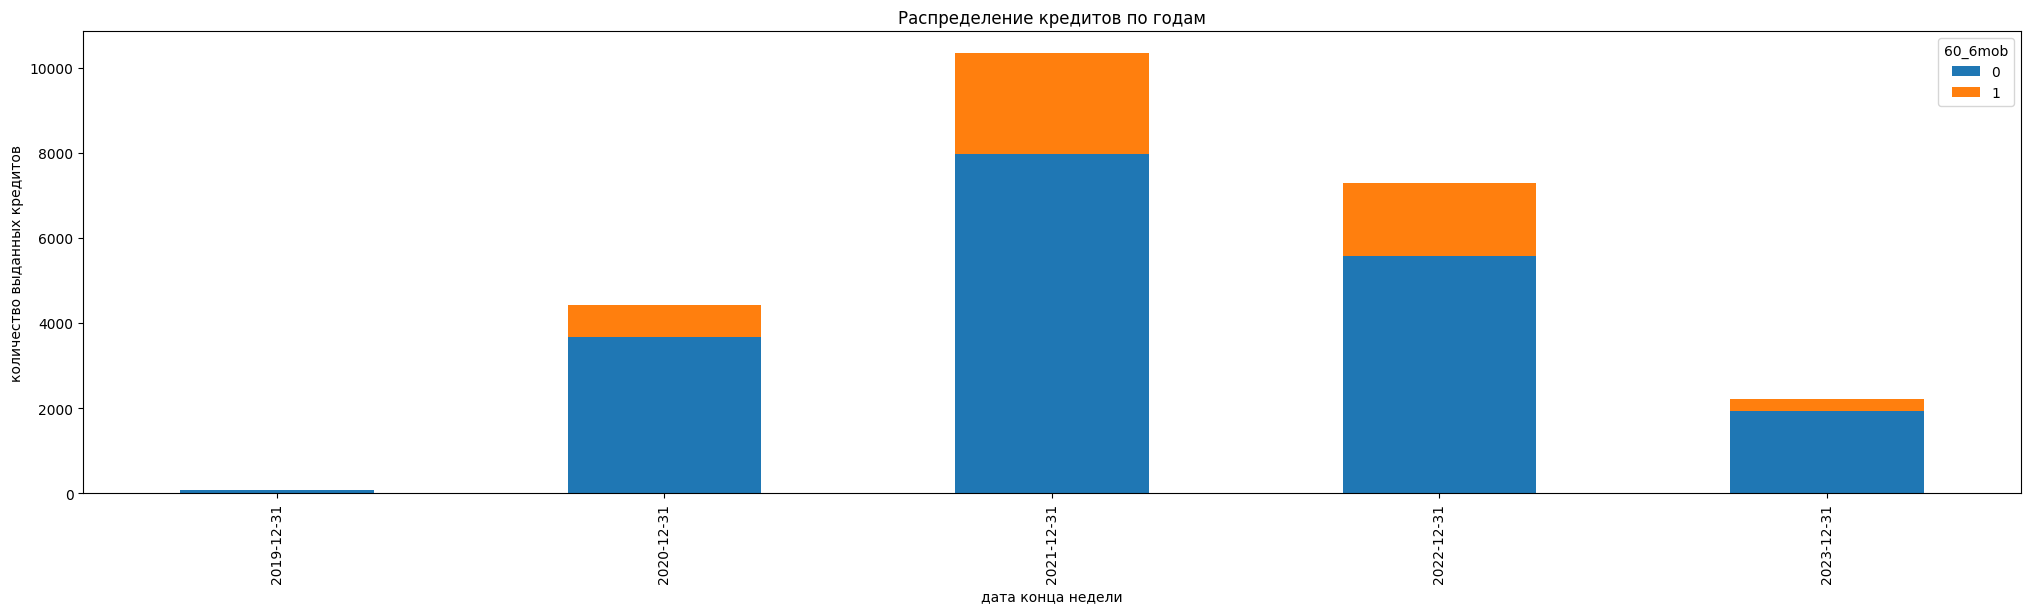

In [29]:
grouped = data.groupby([pd.Grouper(key='dtstart', freq='Y'), '60_6mob'])['seconds'].count().unstack()

fig, ax = plt.subplots(figsize=(25, 6))

grouped.plot(ax=ax, kind='bar', stacked=True, rot=90, title='Распределение кредитов по годам')
ax.set_ylabel('количество выданных кредитов')
ax.set_xlabel('дата конца недели')
ax.set_xticklabels(grouped.index.format())

plt.show()

In [10]:
grouped = data.groupby(pd.Grouper(key='dtstart', freq='D'))  # группировка по дням
mask = grouped['60_6mob'].count().loc[lambda x: x != 0].index  # маска с днями, где есть хоть один выданный кредит

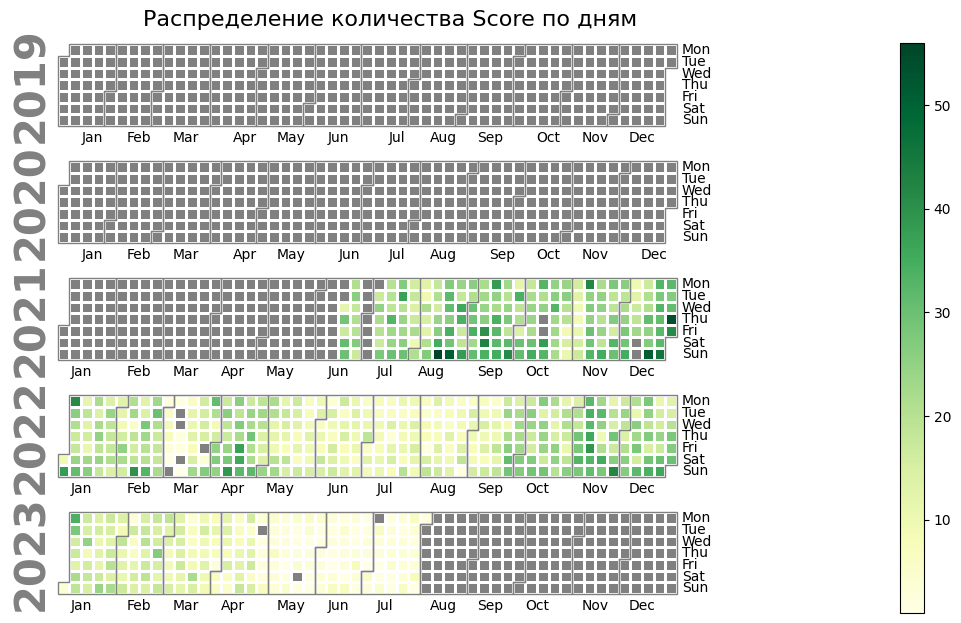

In [31]:
fig, ax = calplot.calplot(
    grouped['Score'].count().loc[mask],
    how=None,
    dropzero=True,
    figsize=(12, 6),
    fillcolor='gray',
    cmap='YlGn',
    yearlabel_kws={'fontname': 'sans-serif'},
    suptitle='Распределение количества Score по дням',
    suptitle_kws={'fontsize': 16},
)

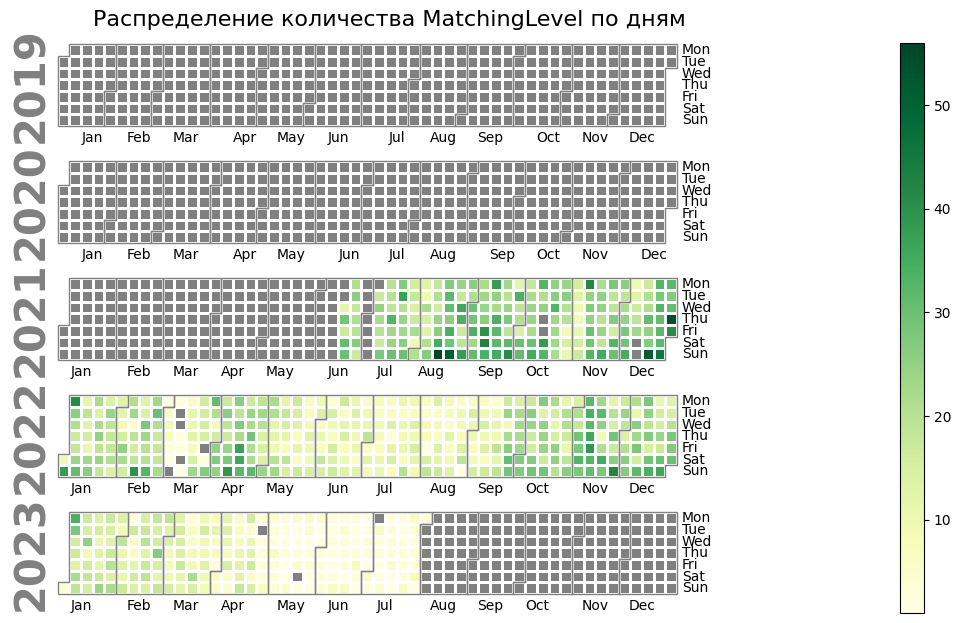

In [32]:
fig, ax = calplot.calplot(
    grouped['MatchingLevel'].count(), #.loc[mask],
    how=None,
    dropzero=True,
    figsize=(12, 6),
    fillcolor='gray',
    cmap='YlGn',
    yearlabel_kws={'fontname': 'sans-serif'},
    suptitle='Распределение количества MatchingLevel по дням',
    suptitle_kws={'fontsize': 16},
)

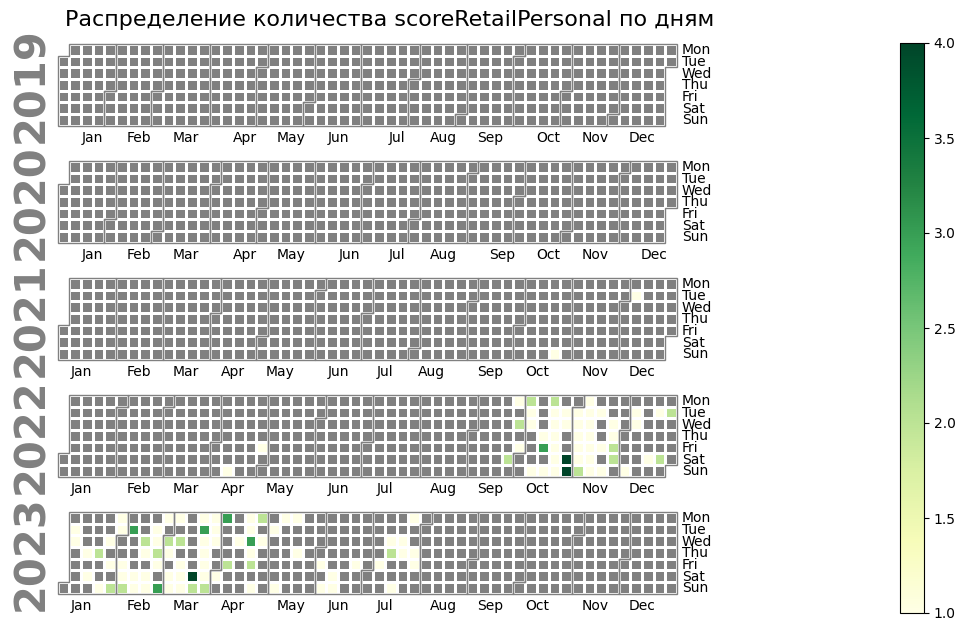

In [33]:
fig, ax = calplot.calplot(
    grouped['scoreRetailPersonal'].count(), #.loc[mask],
    how=None,
    dropzero=True,
    figsize=(12, 6),
    fillcolor='gray',
    cmap='YlGn',
    yearlabel_kws={'fontname': 'sans-serif'},
    suptitle='Распределение количества scoreRetailPersonal по дням',
    suptitle_kws={'fontsize': 16},
)

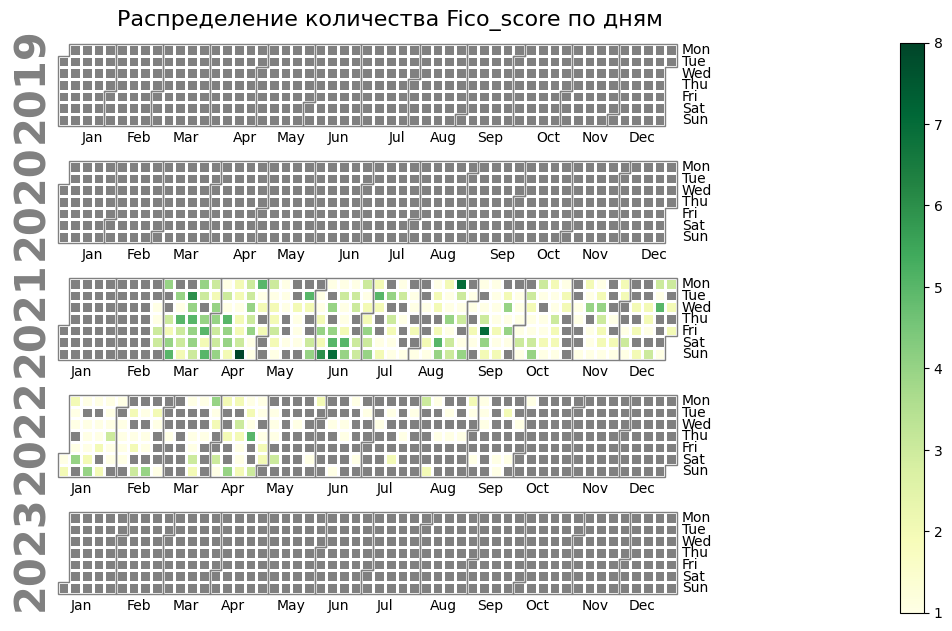

In [34]:
fig, ax = calplot.calplot(
    grouped['Fico_score'].count(), #.loc[mask],
    how=None,
    dropzero=True,
    figsize=(12, 6),
    fillcolor='gray',
    cmap='YlGn',
    yearlabel_kws={'fontname': 'sans-serif'},
    suptitle='Распределение количества Fico_score по дням',
    suptitle_kws={'fontsize': 16},
)

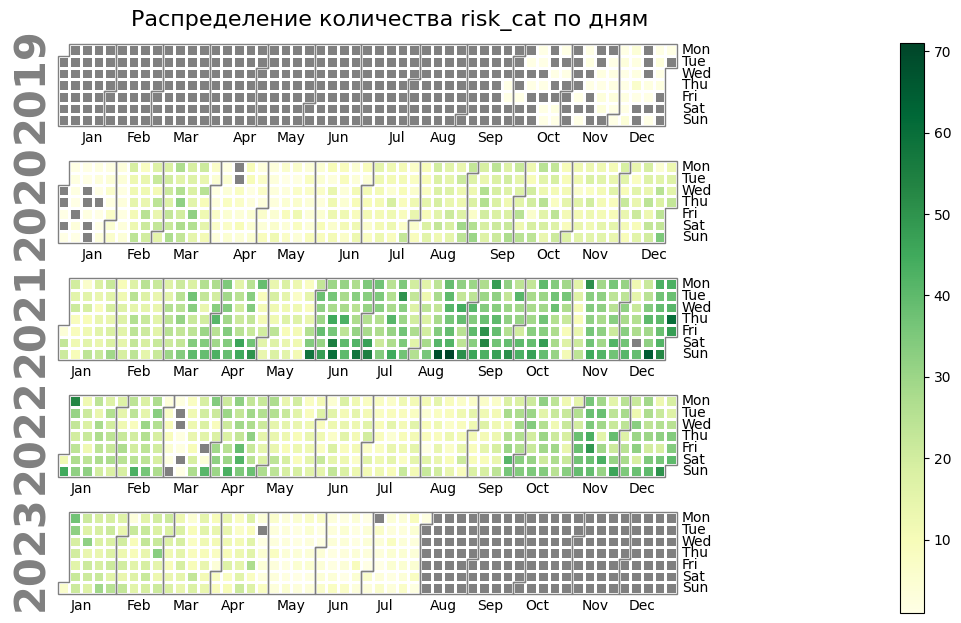

In [35]:
fig, ax = calplot.calplot(
    grouped['risk_cat'].count(), #.loc[mask],
    how=None,
    dropzero=True,
    figsize=(12, 6),
    fillcolor='gray',
    cmap='YlGn',
    yearlabel_kws={'fontname': 'sans-serif'},
    suptitle='Распределение количества risk_cat по дням',
    suptitle_kws={'fontsize': 16},
)

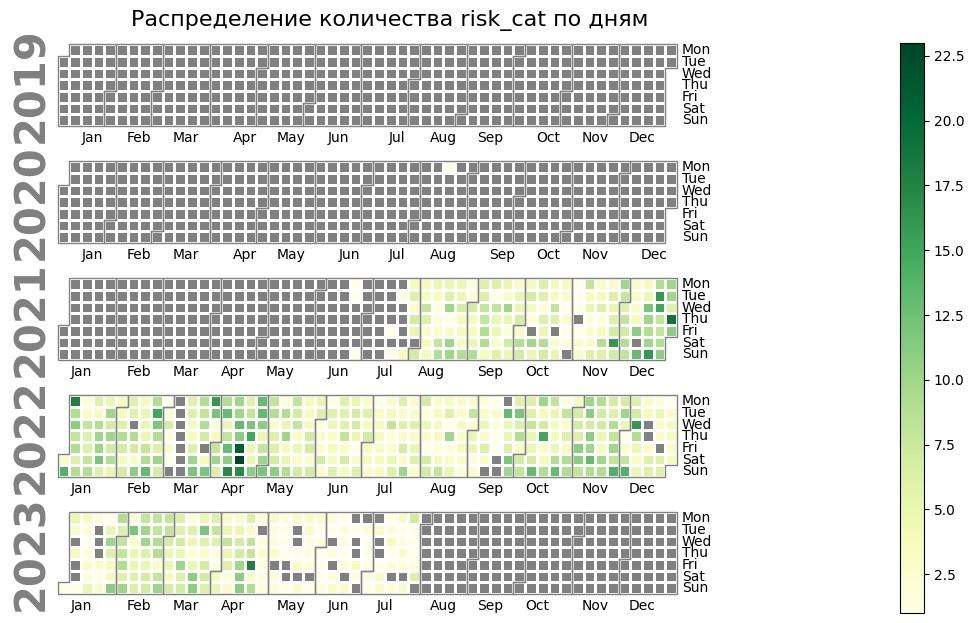

In [11]:
fig, ax = calplot.calplot(
    grouped['RCC_overdue_amount_eq'].count(), #.loc[mask],
    how=None,
    dropzero=True,
    figsize=(12, 6),
    fillcolor='gray',
    cmap='YlGn',
    yearlabel_kws={'fontname': 'sans-serif'},
    suptitle='Распределение количества risk_cat по дням',
    suptitle_kws={'fontsize': 16},
)

### Top 8 shap

### `creditperiod` - Срок кредита плановый

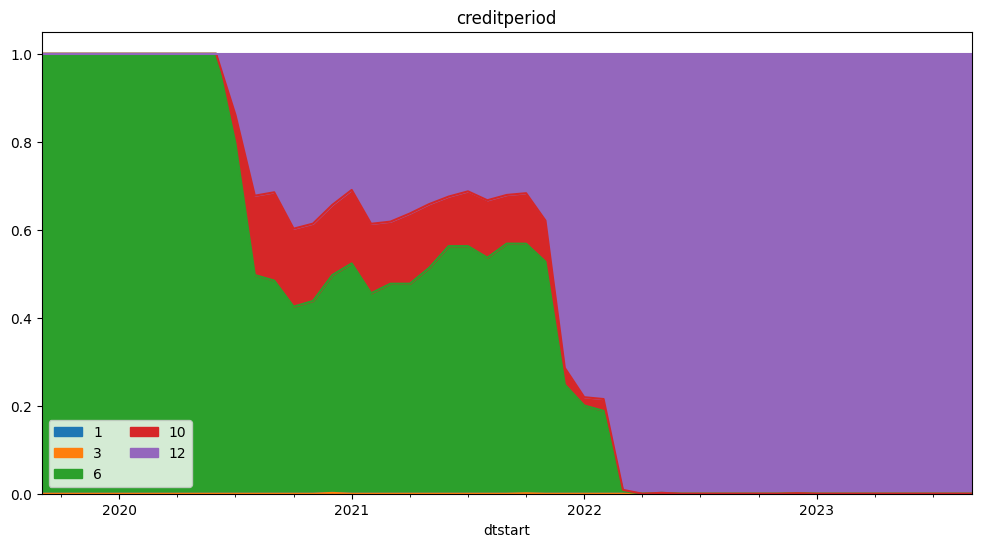

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
area_plot(data, feature_colname='creditperiod', date_colname=DATE_COLNAME, freq='M', ax=ax)
ax.legend(loc='lower left', ncol=2, facecolor='white')
plt.show()

### `LIFETIMEBINValueId` - оценка предполагаемой платежеспособности клиента на основе анализа данных по сроку использования номера телефона

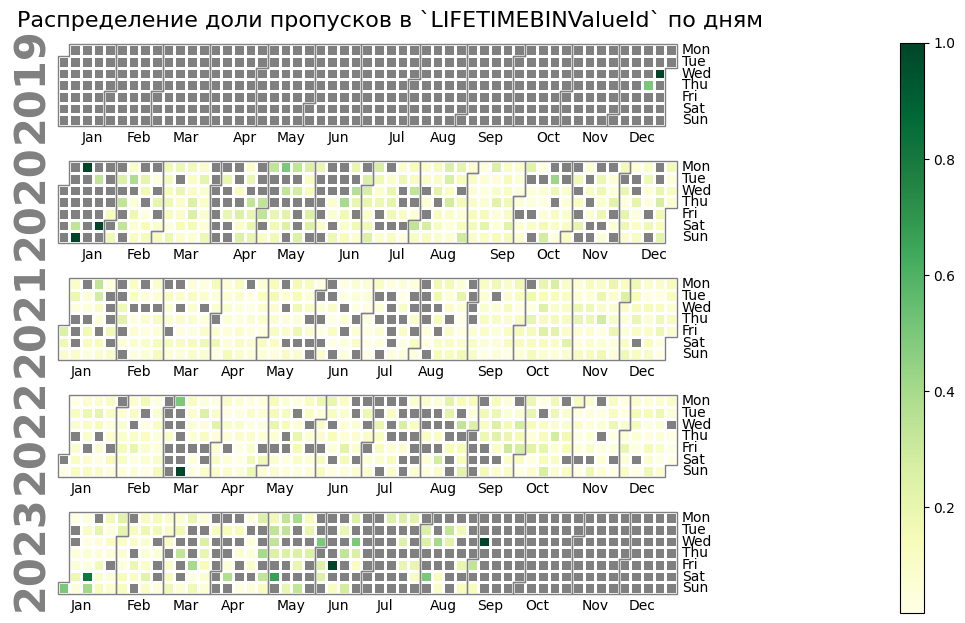

In [8]:
fig, ax = na_datashift(
    data,
    feature_colname='LIFETIMEBINValueId',
    target_colname=TARGET_COLNAME,
    date_colname=DATE_COLNAME,
    figsize=(12, 6),
)

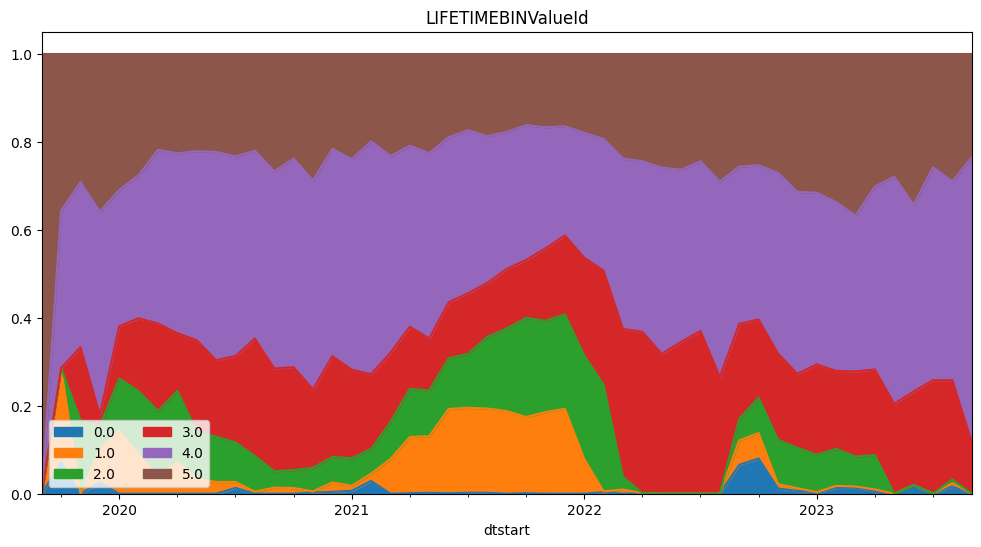

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
area_plot(data, feature_colname='LIFETIMEBINValueId', date_colname=DATE_COLNAME, freq='M', ax=ax)
ax.legend(loc='lower left', ncol=2, facecolor='white')
plt.show()

### `sex` - пол

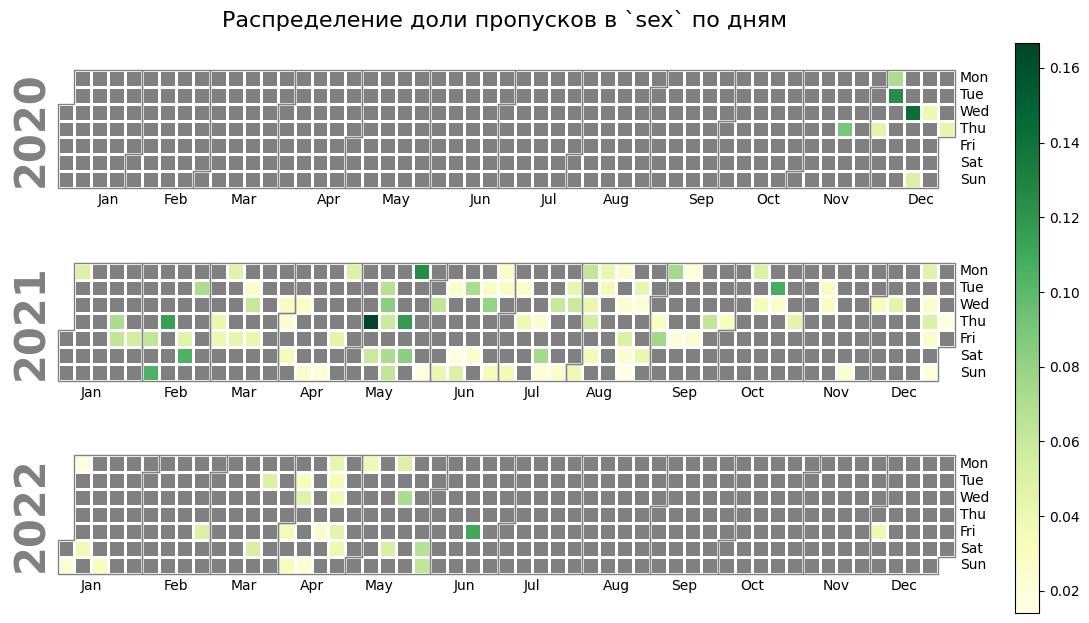

In [11]:
fig, ax = na_datashift(
    data,
    feature_colname='sex',
    target_colname=TARGET_COLNAME,
    date_colname=DATE_COLNAME,
    figsize=(12, 6),
)

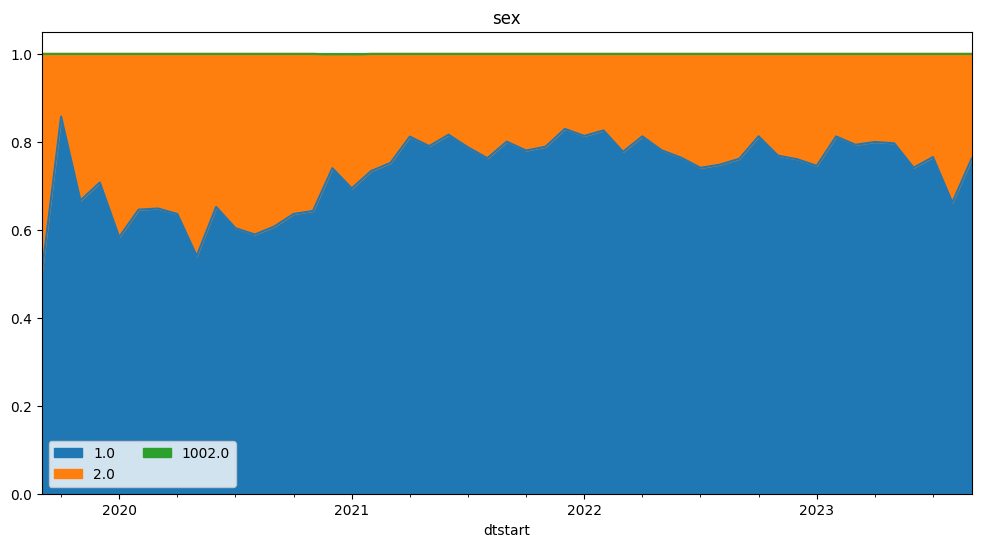

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
area_plot(data, feature_colname='sex', date_colname=DATE_COLNAME, freq='M', ax=ax)
ax.legend(loc='lower left', ncol=2, facecolor='white')
plt.show()

### `nation` - национальность

In [20]:
data['nation'].isna().sum()

1

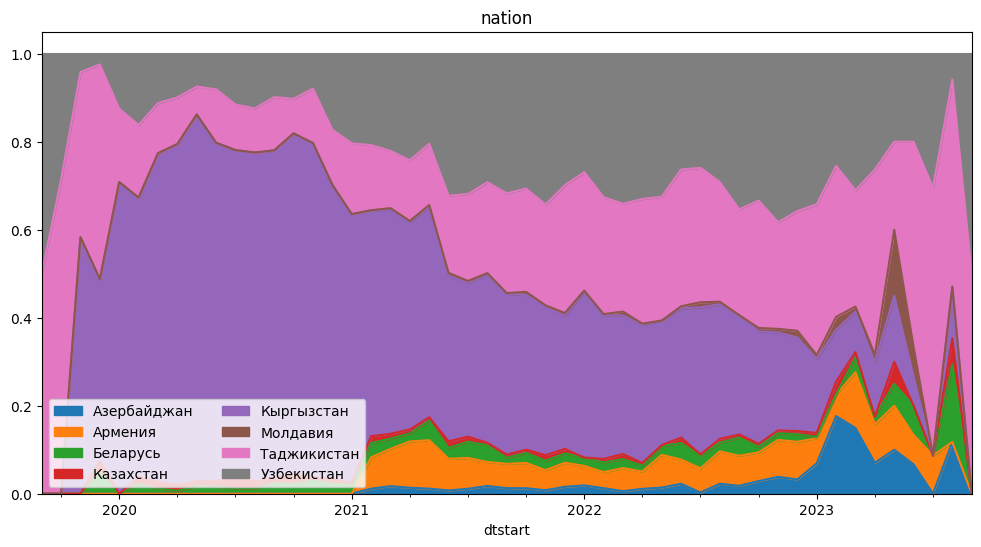

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
area_plot(data, feature_colname='nation', date_colname=DATE_COLNAME, freq='M', ax=ax)
ax.legend(loc='lower left', ncol=2, facecolor='white')
plt.show()

### `age` - возраст

/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


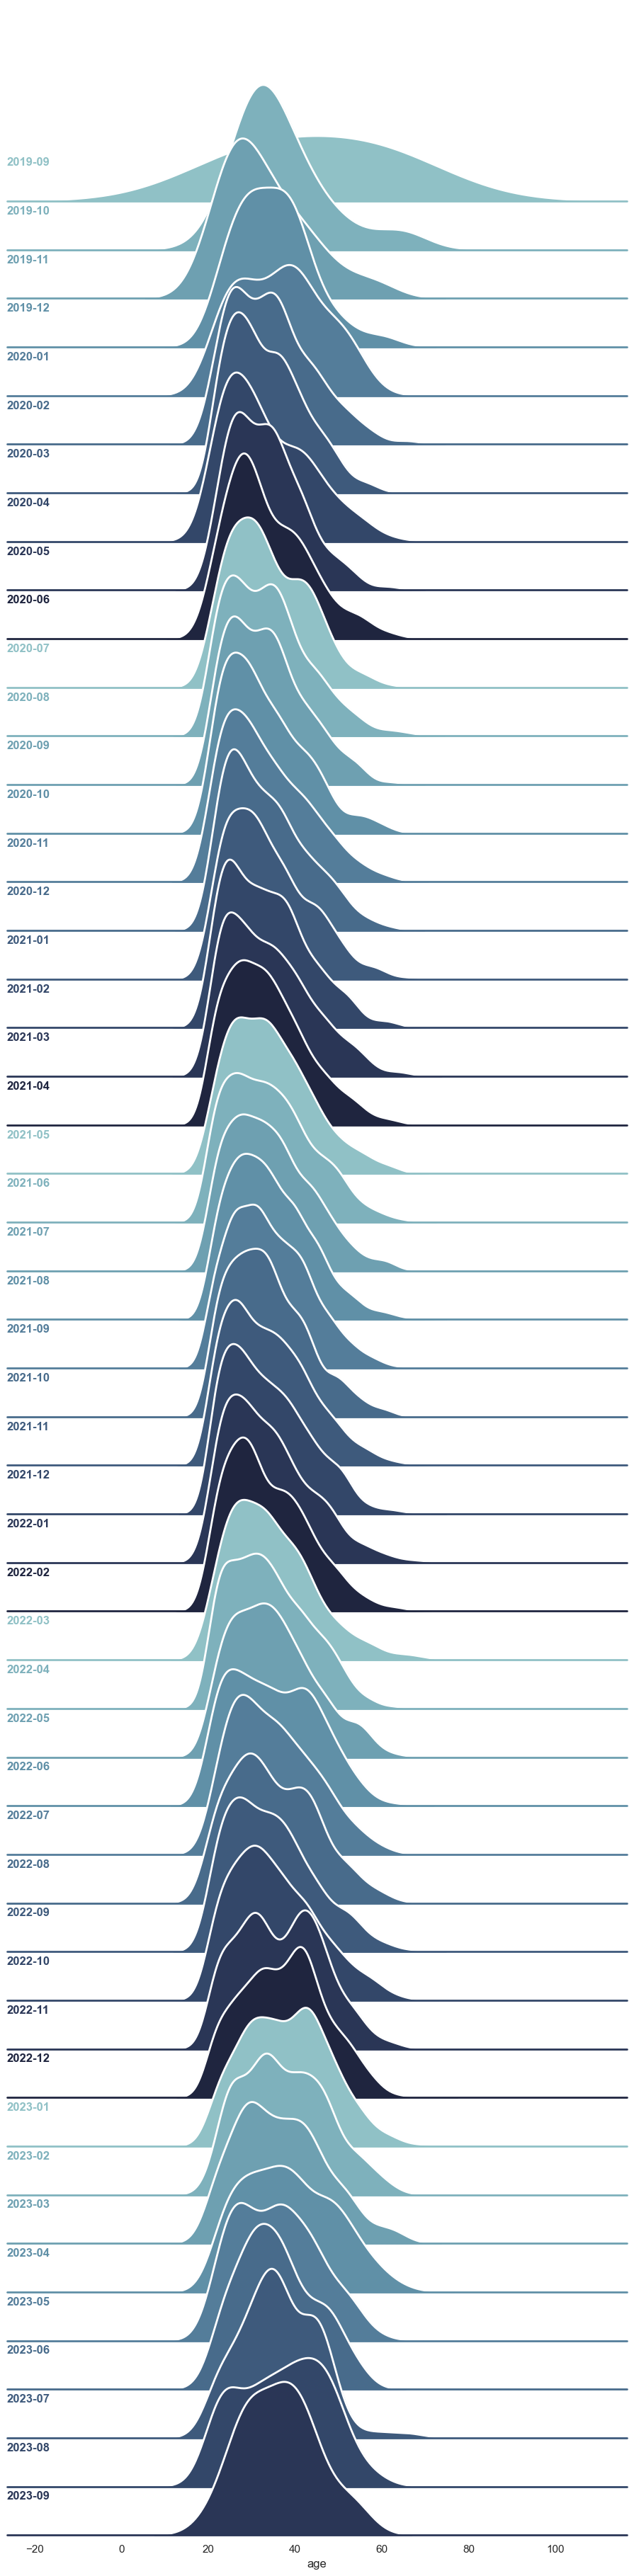

In [14]:
ridge_plot(data, feature_colname='age', date_colname=DATE_COLNAME, freq='M')

### `DOC` - тип документа

In [23]:
data['DOC'].value_counts()

DOC
62.0    6262
45.0    4445
71.0    1869
51.0    1676
48.0    1583
56.0    1261
49.0    1164
64.0     755
46.0     637
1.0      311
2.0      287
55.0     142
53.0      71
3.0       49
66.0      44
60.0      40
7.0       17
65.0      16
5.0       16
68.0       4
63.0       4
67.0       2
Name: count, dtype: int64

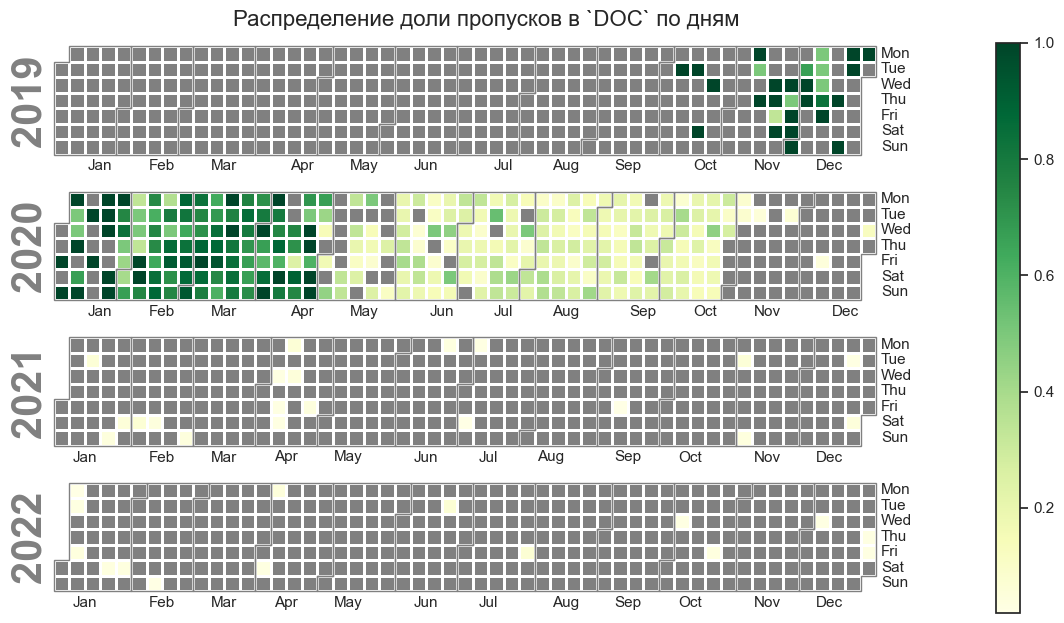

In [24]:
fig, ax = na_datashift(
    data,
    feature_colname='DOC',
    target_colname=TARGET_COLNAME,
    date_colname=DATE_COLNAME,
    freq='D',
    figsize=(12, 6),
)

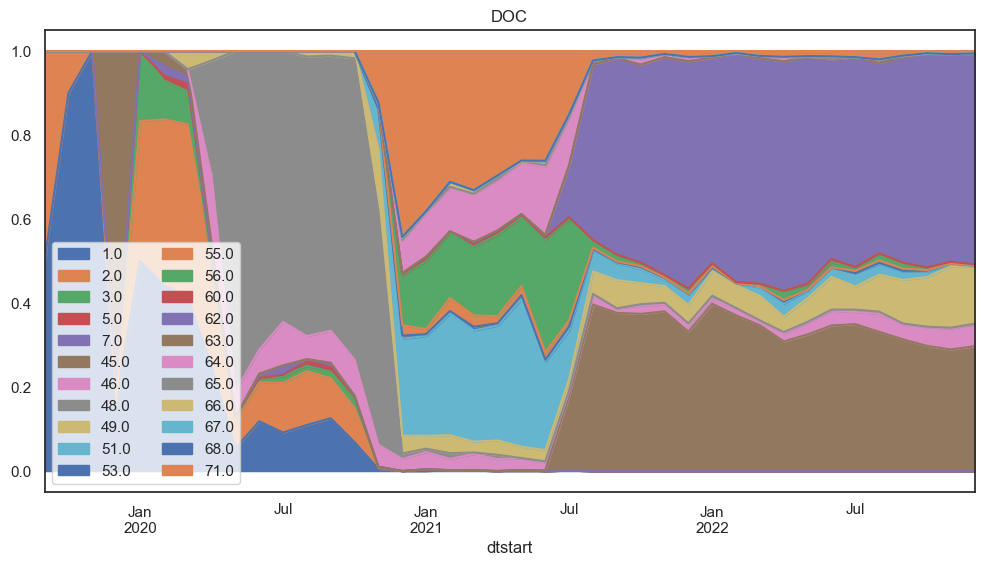

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
area_plot(data, feature_colname='DOC', date_colname=DATE_COLNAME, freq='M', ax=ax)
ax.legend(loc='lower left', ncol=2, facecolor='white')
plt.show()

### `maritalid` - семейное положение

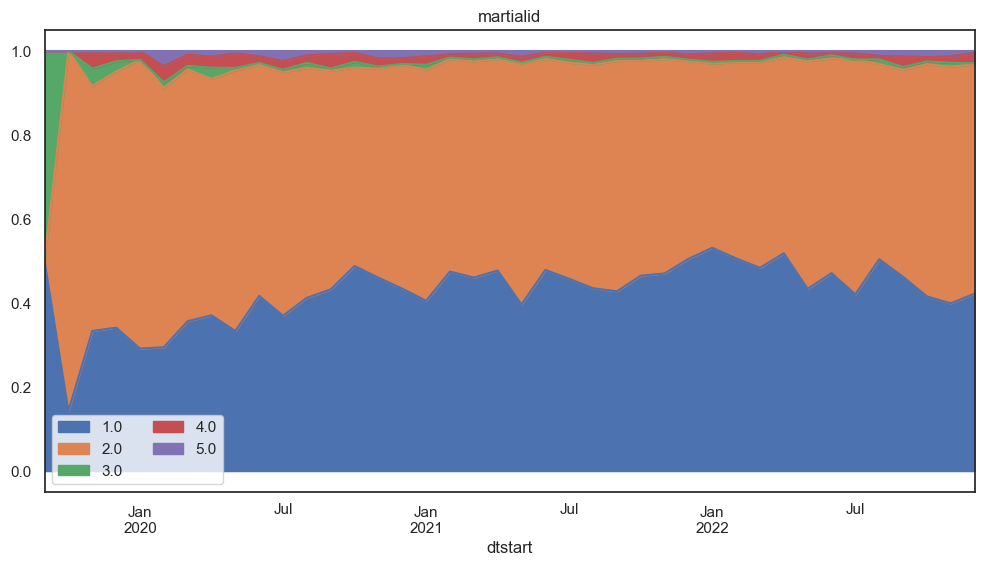

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
area_plot(data, feature_colname='martialid', date_colname=DATE_COLNAME, freq='M', ax=ax)
ax.legend(loc='lower left', ncol=2, facecolor='white')
plt.show()

### `Loan amount` - выданная сумма текущей заявки

/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


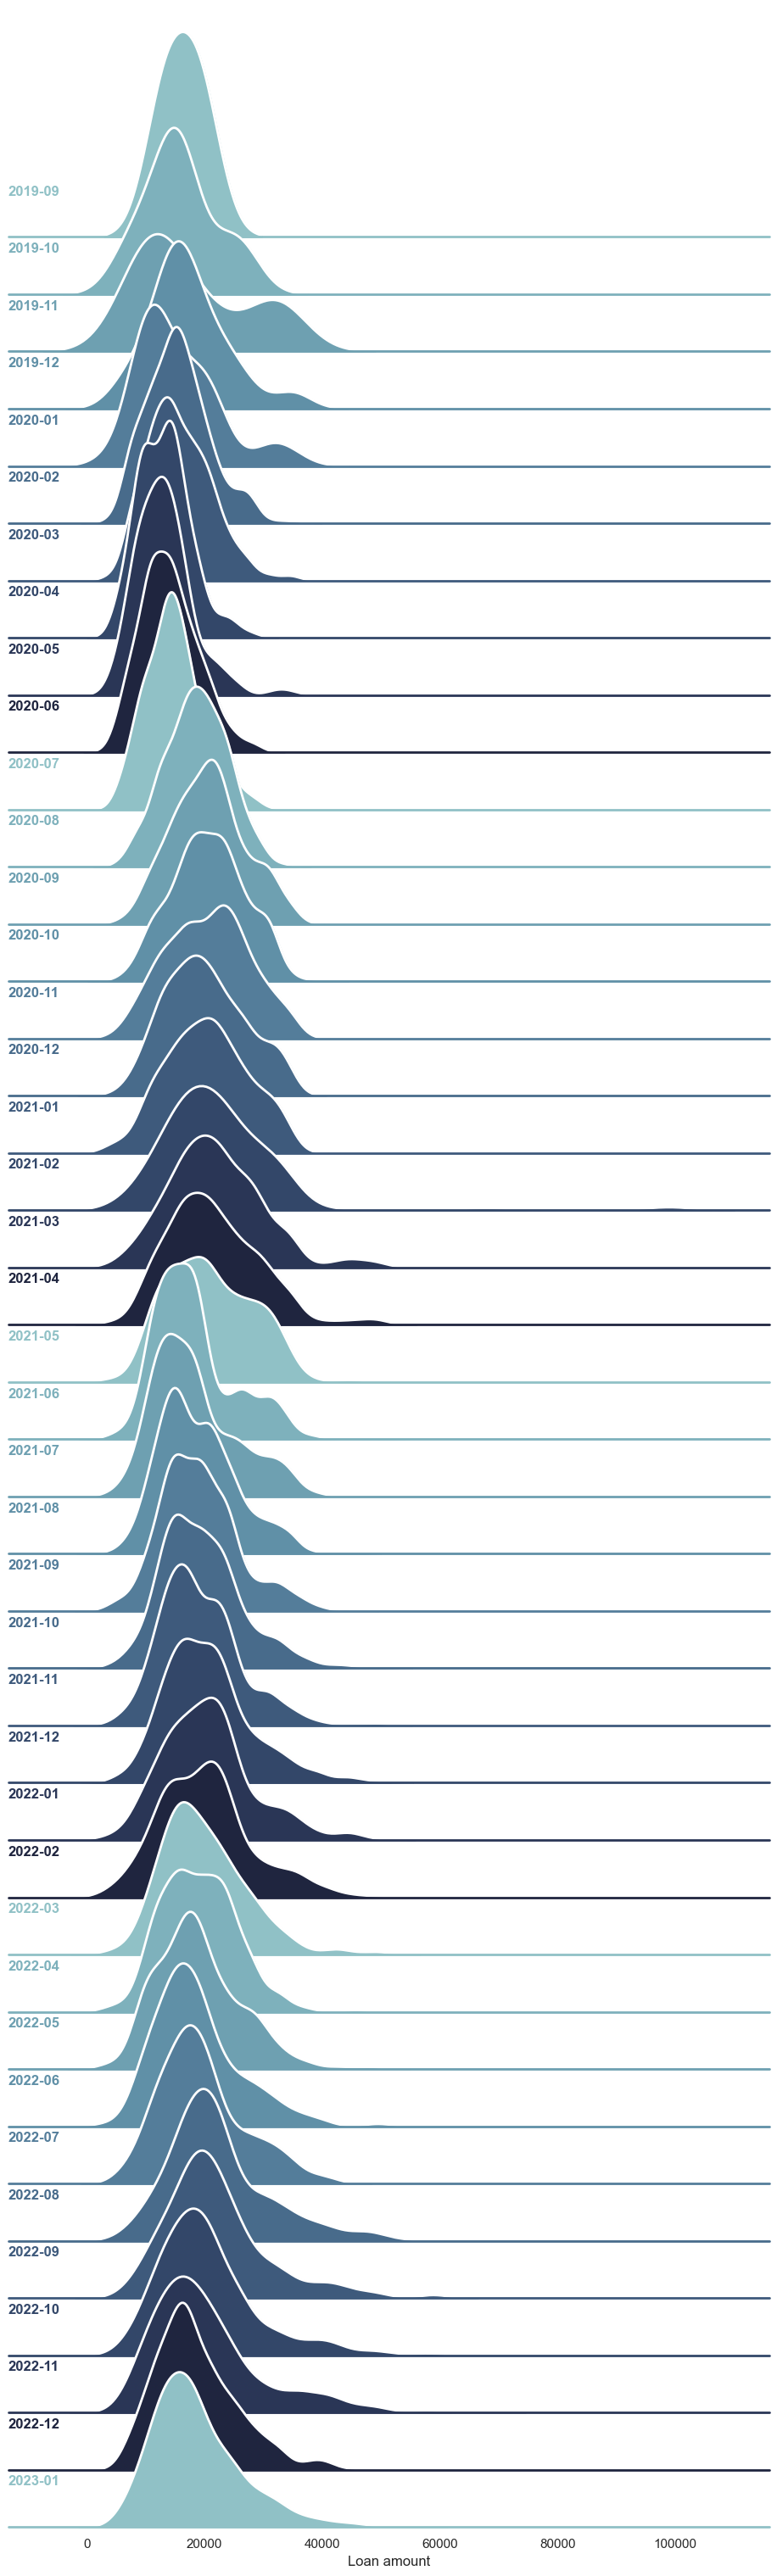

In [22]:
ridge_plot(data, feature_colname='Loan amount', date_colname=DATE_COLNAME, freq='M')

### `AmountPurchaseOriginal` - 

/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/Muminsho/Desktop/work/It_expert/credit-line/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


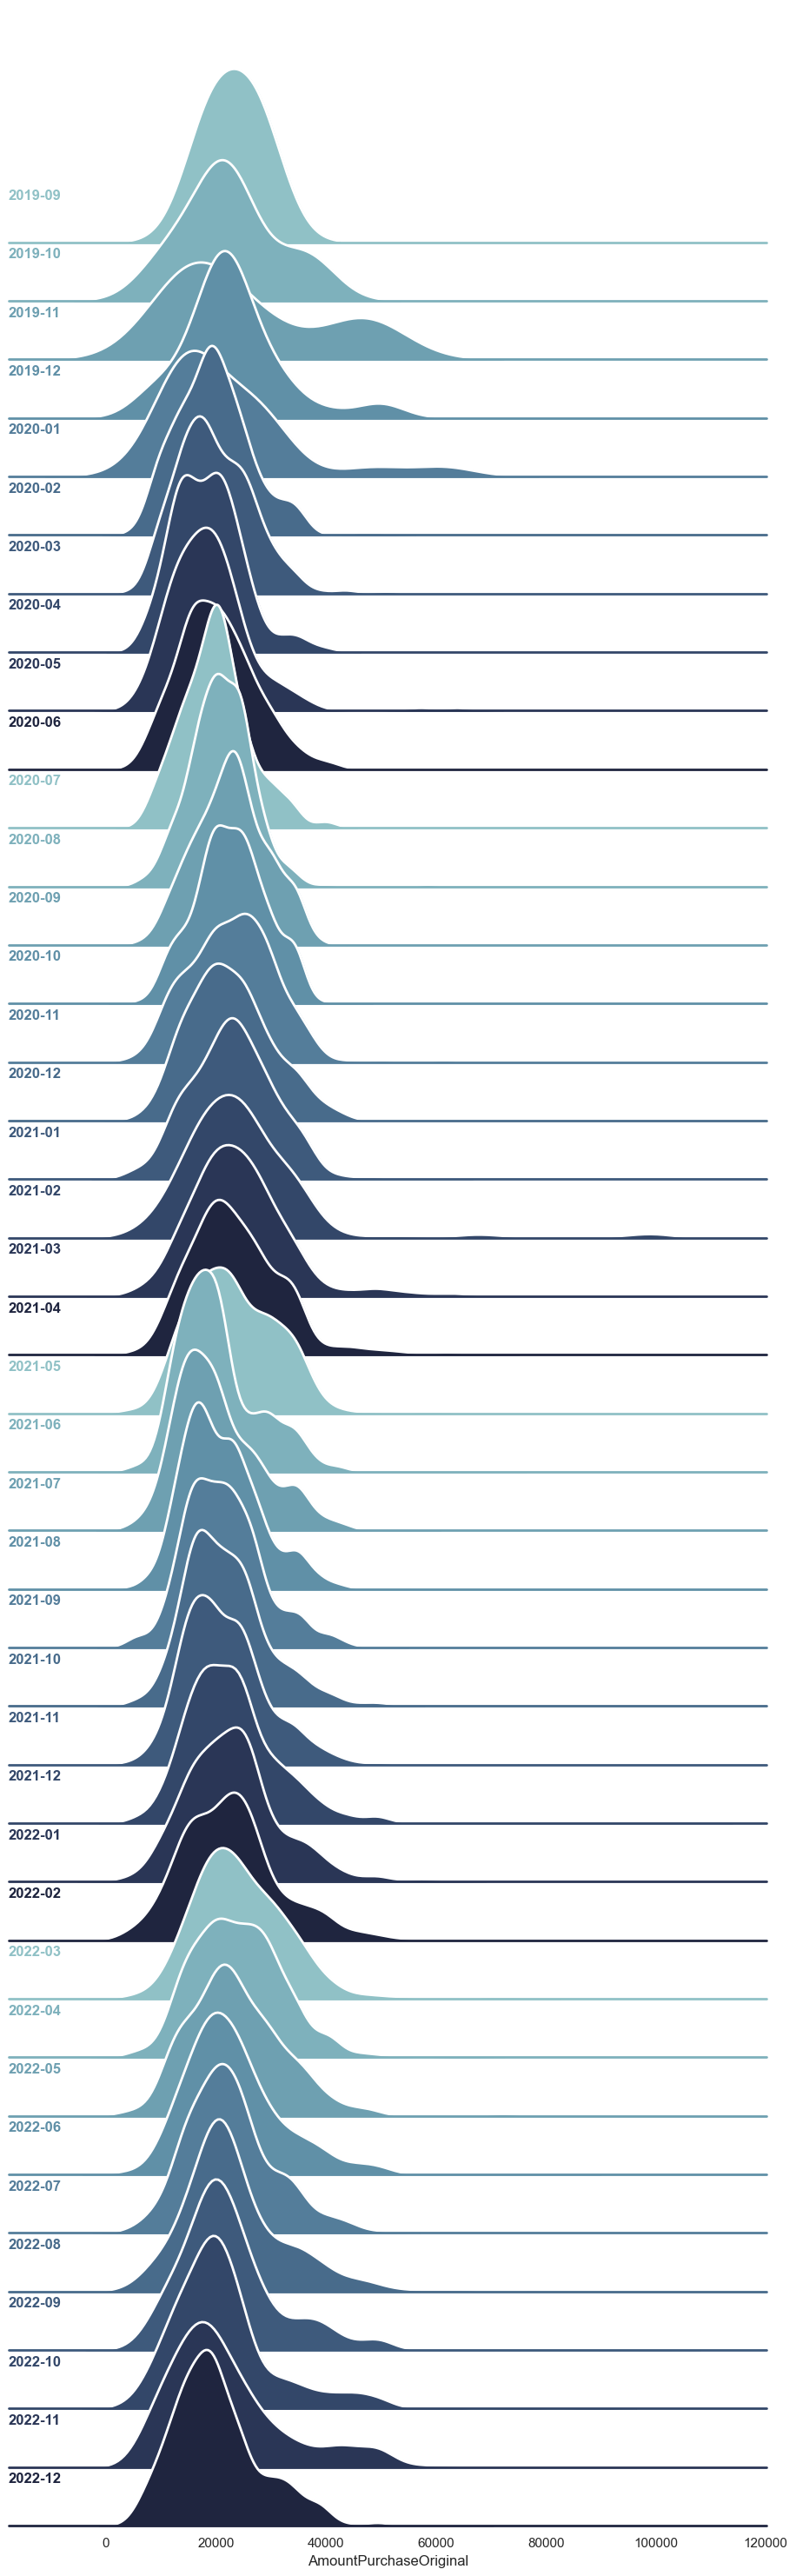

In [28]:
ridge_plot(data, feature_colname='AmountPurchaseOriginal', date_colname=DATE_COLNAME, freq='M')

## CH_length

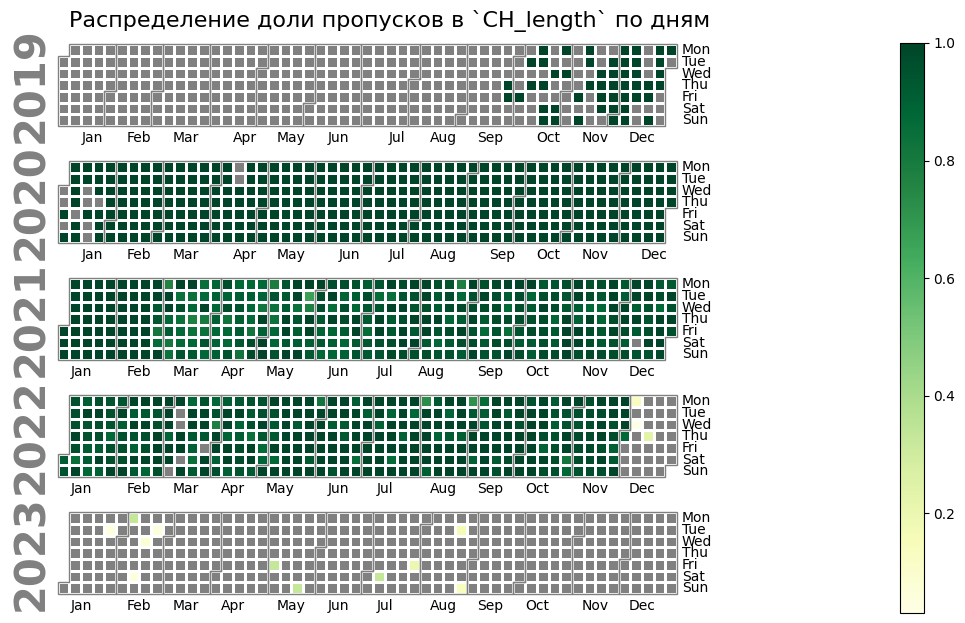

In [11]:
fig, ax = na_datashift(
    data,
    feature_colname='CH_length',
    target_colname=TARGET_COLNAME,
    date_colname=DATE_COLNAME,
    figsize=(12, 6),
)